In [1]:
import pkg_resources
pkg_resources.require("matplotlib==3.1.2")

import pandas as pd
import re
import base64
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import lzma
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from xgboost import XGBClassifier

In [2]:
def optimize_threshold_f1(pred, test):
    ths_array = np.sort(np.unique(pred))
    f1_weighted_auto = []

    for th in tqdm(ths_array, total=ths_array.shape[0]):
        f1_weighted_auto.append(f1_score(test, pred > th, average="weighted"))
        
    return ths_array[np.argmax(f1_weighted_auto)], np.max(f1_weighted_auto)

In [3]:
def get_content(page_base64):
    try:
        return BeautifulSoup(base64.b64decode(page_base64).decode("utf-8"), "html.parser")
    except UnicodeDecodeError:
        return

def get_text(content):
    if content:
        for s in content(["style", "script", "[document]", "head", "title"]):
            s.extract()
        text = content.get_text(separator=" ")
        text = re.sub("\s+", " ", text)
    else:
        text = ""
    return text

def get_words_count(text):
    return len(text.split(' '))

def get_mean_word_length(text):
    word_length_list = [len(word) for word in text.split(' ')]
    return sum(word_length_list) / len(word_length_list)

def get_title_words_count(content):
    title = content.find("title")
    if title:
        return len(title.get_text().split())
    else:
        return 0

def get_compression_value(html):
    return len(html) / len(lzma.compress(html))

def get_anchor_words_count(content):
    anchor_list = [anchor.get_text() for anchor in content.find_all("a")]
    counter = 0
    for anchor in anchor_list:
        counter += len(anchor.split(' '))
    return counter



def take_them_all(page_base64):
    try:
        content = get_content(page_base64)
        compression_value = get_compression_value(base64.b64decode(page_base64))
        if content:
            title_words_count = get_title_words_count(content)
            anchor_words_count = get_anchor_words_count(content)

            text = get_text(content)
            words_count = get_words_count(text)
            mean_word_length = get_mean_word_length(text)

            return (words_count, mean_word_length,
                    title_words_count, compression_value, anchor_words_count)
        
        else:
            return "Error"
    
    except Exception as e:
        print(page_base64)
        raise e


def get_links_number(page_base64):
    content = get_content(page_base64)
    if content:
        return len(content.find_all("a"))

In [5]:
with open("./train_handled.txt") as f:
    train = f.read()
    
train = train.split("\t")

In [108]:
vectorizer = TfidfVectorizer(max_features=1000)
train_vect = vectorizer.fit_transform(train).todense()

In [6]:
df_train = pd.read_csv("/Users/michelle/data/kaggle_train_data_tab.csv", sep="\t")

In [7]:
tqdm.pandas()
df_train["features"] = df_train["PageBase64"].progress_apply(take_them_all)

df_train = df_train.drop(df_train[df_train["features"] == "Error"].index, 0)

for feature in range(5):
    df_train[f"{feature}_feature"] = df_train["features"].apply(lambda x: float(x[feature]))

df_train = df_train.drop(["features"], 1)

/usr/local/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [132]:
X = np.array(df_train[[f"{feature}_feature" for feature in range(5)]])
y = np.array(df_train["Prediction"])

In [104]:
th = 0
f1_weighted_auto = 0

# train_subset = [f"{feature}_feature" for feature in range(5)] + ["link_value"]

for train_indices, test_indices in kfold.split(y):
#     model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    model = XGBClassifier()
    
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    model.fit(X_train, y_train)
    
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    tmp_th, tmp_f1_weighted_auto = optimize_threshold_f1(model.predict_proba(X_test)[:, 1], y_test)
    
    th += tmp_th
    f1_weighted_auto += tmp_f1_weighted_auto
    

th /= kfold.get_n_splits()
f1_weighted_auto /= kfold.get_n_splits()
print(th, f1_weighted_auto)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



0.514238041639328 0.8131754026318987


In [134]:
X = np.hstack((train_vect, X))

In [111]:
th = 0
f1_weighted_auto = 0

for train_indices, val_indices in kfold.split(y):
    model = XGBClassifier()
    
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    model.fit(X_train, y_train)
    
    X_val = X[val_indices, :]
    y_val = y[val_indices]
    tmp_th, tmp_f1_weighted_auto = optimize_threshold_f1(model.predict_proba(X_val)[:, 1], y_val)
    
    th += tmp_th
    f1_weighted_auto += tmp_f1_weighted_auto
    

th /= kfold.get_n_splits()
f1_weighted_auto /= kfold.get_n_splits()
print(th, f1_weighted_auto)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



0.5728421449661255 0.9419619046032333


In [117]:
model = XGBClassifier()
model.fit(X, y)
pred = model.predict_proba(X)[:, 1]
optimize_threshold_f1(pred, y)

(0.54986566, 0.9600442449481325)

In [122]:
import pickle
pickle.dump(model, open("model_08_01.pkl", 'wb'))

In [8]:
with open("./test_handled.txt") as f:
    test = f.read()

In [9]:
test = test.split("\t")

In [120]:
test_vect = vectorizer.transform(test).todense()

In [10]:
df_test = pd.read_csv("/Users/michelle/data/kaggle_test_data_tab.csv", sep='\t')

In [11]:
tqdm.pandas()
df_test["features"] = df_test["PageBase64"].progress_apply(take_them_all)

df_test = df_test.drop(df_test[df_test["features"] == "Error"].index, 0)

for feature in range(5):
    df_test[f"{feature}_feature"] = df_test["features"].apply(lambda x: float(x[feature]))

df_test = df_test.drop(["features"], 1)

In [129]:
X_test = np.hstack((test_vect, np.array(df_test[[f"{feature}_feature" for feature in range(5)]])))

In [130]:
pred = model.predict_proba(X_test)[:, 1]
df_test["Prediction"] = pred > th
df_test["Prediction"] = df_test["Prediction"].apply(lambda x: int(x))
df_test.head()

,Id,Prediction,Url,PageBase64,0_feature,1_feature,2_feature,3_feature,4_feature
0,-9219333997282093076,1,http://laventuhhl.ohugi.com/igor-znakomstva-ni...,PGh0bWw+DQoNCjxoZWFkPg0KPE1FVEEgY29udGVudD0idG...,771.0,5.979248,9.0,3.247172,79.0
1,-9216796593526314243,1,http://myachina9abbee.front.ru/allinone.html,PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...,485.0,5.536082,5.0,2.879384,72.0
2,-9216634615606576667,0,http://petropavl.kz/whouse/autor/autor4.shtml,PCEtLdCY0LTQtdGPINGB0L7Qt9C00LDQvdC40Y8g0Lgg0L...,220.0,6.559091,13.0,3.344770,24.0
3,-9215626373068452590,0,http://astro-online.ru/synastry.html,CjwhRE9DVFlQRSBIVE1MIFBVQkxJQyAiLS8vVzNDLy9EVE...,3008.0,6.550199,4.0,11.130094,48.0
4,-9215403080479774736,1,http://oxoyhetc.hopto.org/13/62.html,DQoNCg0KPEhUTUw+DQo8SEVBRD4NCjx0aXRsZT7QotC10L...,665.0,6.225564,7.0,3.609824,95.0


In [128]:
pred = model.predict_proba(X_test)[:, 1]
df_test["Prediction"] = pred > th
df_test["Prediction"] = df_test["Prediction"].apply(lambda x: int(x))
df_test.head()
df_test.loc[:, ["Id", "Prediction"]].to_csv("antispam_submission_08_01.csv", index=False)

In [131]:
def train_model(X, y):
    th = 0
    f1_weighted_auto = 0


    for train_indices, val_indices in kfold.split(y):
        model = XGBClassifier()

        X_train = X[train_indices, :]
        y_train = y[train_indices]
        model.fit(X_train, y_train)

        X_val = X[val_indices, :]
        y_val = y[val_indices]
        tmp_th, tmp_f1_weighted_auto = optimize_threshold_f1(model.predict_proba(X_val)[:, 1], y_val)

        th += tmp_th
        f1_weighted_auto += tmp_f1_weighted_auto


    th /= kfold.get_n_splits()
    f1_weighted_auto /= kfold.get_n_splits()
    
    return th, f1_weighted_auto

In [135]:
train_model(X, y)

(0.5728421449661255, 0.9419619046032333)

In [137]:
X = np.array(df_train[[f"{feature}_feature" for feature in range(5)]])
y = np.array(df_train["Prediction"])

In [141]:
for features in [2000, 5000, 10000]:
    vectorizer = TfidfVectorizer(max_features=features)
    train_vect = vectorizer.fit_transform(train).todense()
    X = np.hstack((train_vect, np.array(df_train[[f"{feature}_feature" for feature in range(5)]])))
    print(features, train_model(X, y))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



2000 (0.5517725348472595, 0.9445852136807428)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



5000 (0.519924646615982, 0.9432889811635599)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



10000 (0.5474193036556244, 0.9447407591277617)


In [12]:
tqdm.pandas()
df_train["links_value"] = df_train["PageBase64"].progress_apply(get_links_number) / df_train["0_feature"]

In [143]:
train_subset = [f"{feature}_feature" for feature in range(5)] + ["links_value"]

In [145]:
# for features in [2000, 5000, 10000]:
vectorizer = TfidfVectorizer(max_features=2000)
train_vect = vectorizer.fit_transform(train).todense()
X = np.hstack((train_vect, np.array(df_train[train_subset])))
print(features, train_model(X, y))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



10000 (0.47043628096580503, 0.9492842637632629)


In [15]:
def get_unique_words_ratio(data):
    counts = []
    for text in data:
        splited_text = text.split(" ")
        counts.append(len(set(splited_text)) / len(splited_text))
    return counts

In [16]:
df_train["unique_words_ratio"] = get_unique_words_ratio(train)

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


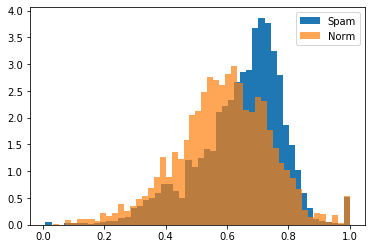

In [171]:
plt.hist(df_train[(df_train["Prediction"] == 1)]["unique_words_ratio"], bins=50, label="Spam", normed=True)
plt.hist(df_train[(df_train["Prediction"] == 0)]["unique_words_ratio"], bins=50, label="Norm", normed=True, alpha=0.7)
plt.legend()

In [172]:
train_subset = [f"{feature}_feature" for feature in range(5)] + ["links_value", "unique_words_ratio"]
vectorizer = TfidfVectorizer(max_features=2000)
train_vect = vectorizer.fit_transform(train).todense()
X = np.hstack((train_vect, np.array(df_train[train_subset])))
print(features, train_model(X, y))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



10000 (0.5103693723678588, 0.9512057165912967)


In [173]:
model = XGBClassifier()
model.fit(X, y)
pred = model.predict_proba(X)[:, 1]
optimize_threshold_f1(pred, y)

(0.46827012, 0.9672179424461164)

In [178]:
import pickle
pickle.dump(model, open("model_08_02.pkl", 'wb'))

In [14]:
df_test["unique_words_ratio"] = get_unique_words_ratio(test)

NameError: name 'get_unique_words_ratio' is not defined

In [ ]:
tqdm.pandas()
df_test["links_value"] = df_test["PageBase64"].progress_apply(get_links_number) / df_test["0_feature"]

In [181]:
test_vect = vectorizer.transform(test).todense()

In [182]:
X_test = np.hstack((test_vect, np.array(df_test[train_subset])))

In [186]:
th = 0.5103693723678588
pred = model.predict_proba(X_test)[:, 1]
df_test["Prediction"] = pred > th
df_test["Prediction"] = df_test["Prediction"].apply(lambda x: int(x))
df_test.loc[:, ["Id", "Prediction"]].to_csv("antispam_submission_08_02.csv", index=False)
df_test.head() # 0.92 on leaderboard

,Id,Prediction,Url,PageBase64,0_feature,1_feature,2_feature,3_feature,4_feature,unique_words_ratio,links_value
0,-9219333997282093076,1,http://laventuhhl.ohugi.com/igor-znakomstva-ni...,PGh0bWw+DQoNCjxoZWFkPg0KPE1FVEEgY29udGVudD0idG...,771.0,5.979248,9.0,3.247172,79.0,0.749540,0.029831
1,-9216796593526314243,0,http://myachina9abbee.front.ru/allinone.html,PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...,485.0,5.536082,5.0,2.879384,72.0,0.747875,0.074227
2,-9216634615606576667,0,http://petropavl.kz/whouse/autor/autor4.shtml,PCEtLdCY0LTQtdGPINGB0L7Qt9C00LDQvdC40Y8g0Lgg0L...,220.0,6.559091,13.0,3.344770,24.0,0.678571,0.095455
3,-9215626373068452590,0,http://astro-online.ru/synastry.html,CjwhRE9DVFlQRSBIVE1MIFBVQkxJQyAiLS8vVzNDLy9EVE...,3008.0,6.550199,4.0,11.130094,48.0,0.467682,0.010971
4,-9215403080479774736,1,http://oxoyhetc.hopto.org/13/62.html,DQoNCg0KPEhUTUw+DQo8SEVBRD4NCjx0aXRsZT7QotC10L...,665.0,6.225564,7.0,3.609824,95.0,0.757261,0.034586


In [188]:
from sklearn.model_selection import GridSearchCV

In [18]:
train_subset = [f"{feature}_feature" for feature in range(5)] + ["links_value", "unique_words_ratio"]

In [19]:
vectorizer = TfidfVectorizer(2000)
train_vect = vectorizer.fit_transform(train).todense()

X = np.hstack((train_vect, np.array(df_train[train_subset])))

In [24]:
def train_model(X, y):
    th = 0
    f1_weighted_auto = 0

    kfold = KFold(5)
    for train_indices, val_indices in kfold.split(y):
#         model = XGBClassifier()
        model = CatBoostClassifier()

        X_train = X[train_indices, :]
        y_train = y[train_indices]
        model.fit(X_train, y_train)

        X_val = X[val_indices, :]
        y_val = y[val_indices]
        tmp_th, tmp_f1_weighted_auto = optimize_threshold_f1(model.predict_proba(X_val)[:, 1], y_val)

        th += tmp_th
        f1_weighted_auto += tmp_f1_weighted_auto


    th /= kfold.get_n_splits()
    f1_weighted_auto /= kfold.get_n_splits()
    
    return th, f1_weighted_auto

In [25]:
y = df_train["Prediction"]

In [ ]:
train_model(X, y)